In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import load_model

import tensorflow_datasets as tfds

## Citation

```
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}
```

Also, all thanks to Kylie Ying for the CNN course and this model. https://www.youtube.com/watch?v=nVhau51w6dM


# Data
TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [3]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True) #tensor flow load 'food101' data set 

In [4]:
train_ds, valid_ds = ds["train"], ds["validation"]

2024-06-26 12:46:15.643847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


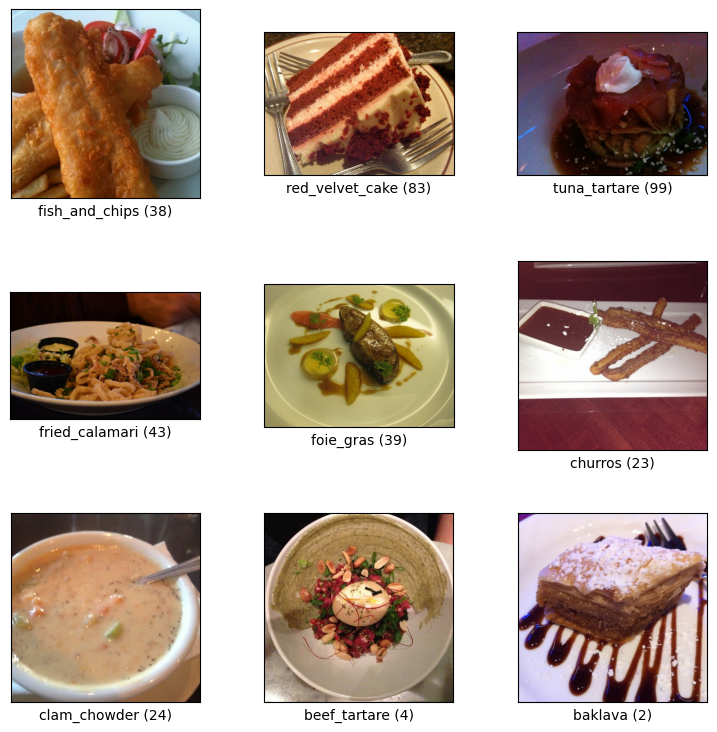

In [5]:
fig = tfds.show_examples(train_ds, ds_info)

In [6]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), #lambda: what are the inputs
                          tf.cast(label == HOT_DOG_CLASS, tf.int32)) # whether or not is hot dog class 
)

valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), #lambda: what are the inputs
                          tf.cast(label == HOT_DOG_CLASS, tf.int32)) # whether or not is hot dog class 
)


2024-06-25 11:52:01.398175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


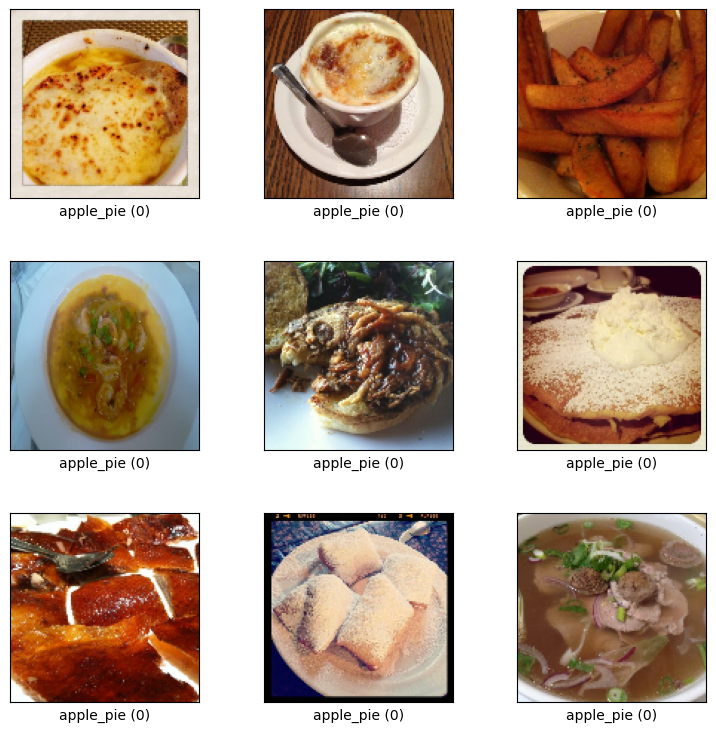

In [6]:
fig = tfds.show_examples(train_ds, ds_info)

In [8]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [9]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [10]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [11]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch)
    print(label_batch)

tf.Tensor(
[[[[ 29  16   8]
   [ 28  15   6]
   [ 31  17   7]
   ...
   [ 45  23   1]
   [ 42  23   5]
   [ 38  20   4]]

  [[ 19   6   0]
   [ 28  15   7]
   [ 30  15   7]
   ...
   [ 59  29   2]
   [ 60  30   5]
   [ 55  26   3]]

  [[ 26  13   5]
   [ 28  16   5]
   [ 33  20   4]
   ...
   [ 69  30   0]
   [ 71  31   1]
   [ 72  31   1]]

  ...

  [[207 208 195]
   [209 210 198]
   [212 213 202]
   ...
   [206 211 205]
   [184 189 183]
   [138 143 138]]

  [[207 207 195]
   [208 208 196]
   [212 212 202]
   ...
   [170 175 169]
   [106 111 104]
   [ 71  75  65]]

  [[209 207 195]
   [212 210 198]
   [214 211 202]
   ...
   [ 76  82  74]
   [134 138 124]
   [199 202 185]]]


 [[[253 255 254]
   [253 254 253]
   [254 254 252]
   ...
   [254 254 254]
   [255 255 255]
   [255 255 255]]

  [[253 254 253]
   [253 255 254]
   [253 255 254]
   ...
   [252 252 252]
   [253 253 253]
   [255 255 255]]

  [[255 255 253]
   [253 255 254]
   [236 240 241]
   ...
   [ 30  30  30]
   [254 254 254]


2024-06-26 12:51:45.637191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-26 12:51:45.660404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Neural Net Implementation

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [12]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
    280/Unknown 358s 1s/step - accuracy: 0.4895 - loss: 1.7273

2024-06-25 11:58:00.732009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


280/280 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.4895 - loss: 1.7266 - val_accuracy: 0.4733 - val_loss: 1.1800
Epoch 2/50


2024-06-25 11:59:05.846868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.5456 - loss: 1.0886

2024-06-25 12:02:02.310917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 192s 688ms/step - accuracy: 0.5457 - loss: 1.0884 - val_accuracy: 0.5267 - val_loss: 0.9083
Epoch 3/50


2024-06-25 12:02:18.350856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.5809 - loss: 0.8765

2024-06-25 12:05:09.719585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 188s 672ms/step - accuracy: 0.5809 - loss: 0.8764 - val_accuracy: 0.5667 - val_loss: 0.8023
Epoch 4/50


2024-06-25 12:05:26.448856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.5957 - loss: 0.7879

2024-06-25 12:08:19.514480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 187s 668ms/step - accuracy: 0.5958 - loss: 0.7878 - val_accuracy: 0.6103 - val_loss: 0.7473
Epoch 5/50


2024-06-25 12:08:33.546335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.6140 - loss: 0.7351

2024-06-25 12:11:26.717682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 187s 669ms/step - accuracy: 0.6140 - loss: 0.7351 - val_accuracy: 0.5927 - val_loss: 0.7180
Epoch 6/50


2024-06-25 12:11:40.880579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.6433 - loss: 0.6910

2024-06-25 12:14:32.589430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 187s 670ms/step - accuracy: 0.6433 - loss: 0.6910 - val_accuracy: 0.6067 - val_loss: 0.6944
Epoch 7/50


2024-06-25 12:14:48.271899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.6633 - loss: 0.6640

2024-06-25 12:17:34.863098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 181s 645ms/step - accuracy: 0.6633 - loss: 0.6640 - val_accuracy: 0.6334 - val_loss: 0.6808
Epoch 8/50


2024-06-25 12:17:48.924523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.6861 - loss: 0.6257

2024-06-25 12:20:44.761784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 190s 679ms/step - accuracy: 0.6862 - loss: 0.6256 - val_accuracy: 0.6236 - val_loss: 0.6707
Epoch 9/50


2024-06-25 12:20:58.903058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.7173 - loss: 0.5865

2024-06-25 12:23:49.978122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 185s 660ms/step - accuracy: 0.7174 - loss: 0.5864 - val_accuracy: 0.6110 - val_loss: 0.6789
Epoch 10/50


2024-06-25 12:24:03.576685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.7515 - loss: 0.5427

2024-06-25 12:27:01.170358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 191s 684ms/step - accuracy: 0.7516 - loss: 0.5426 - val_accuracy: 0.6180 - val_loss: 0.7170
Epoch 11/50


2024-06-25 12:27:15.004155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7975 - loss: 0.4884

2024-06-25 12:30:22.346331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 201s 718ms/step - accuracy: 0.7975 - loss: 0.4884 - val_accuracy: 0.6194 - val_loss: 0.7336
Epoch 12/50


2024-06-25 12:30:35.887536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.8265 - loss: 0.4449

2024-06-25 12:33:39.743641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 197s 705ms/step - accuracy: 0.8266 - loss: 0.4448 - val_accuracy: 0.6180 - val_loss: 0.8045
Epoch 13/50


2024-06-25 12:33:53.268463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8515 - loss: 0.4109

2024-06-25 12:36:45.519781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 186s 664ms/step - accuracy: 0.8516 - loss: 0.4108 - val_accuracy: 0.6278 - val_loss: 0.7950
Epoch 14/50


2024-06-25 12:36:59.052385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8821 - loss: 0.3493

2024-06-25 12:39:51.177781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 185s 661ms/step - accuracy: 0.8822 - loss: 0.3492 - val_accuracy: 0.6397 - val_loss: 0.8372
Epoch 15/50


2024-06-25 12:40:04.120768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9112 - loss: 0.3055

2024-06-25 12:42:44.331501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 173s 617ms/step - accuracy: 0.9112 - loss: 0.3054 - val_accuracy: 0.6369 - val_loss: 0.9022
Epoch 16/50


2024-06-25 12:42:56.780953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9239 - loss: 0.2786

2024-06-25 12:45:51.285805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


280/280 ━━━━━━━━━━━━━━━━━━━━ 189s 675ms/step - accuracy: 0.9239 - loss: 0.2785 - val_accuracy: 0.6194 - val_loss: 0.9741
Epoch 17/50


2024-06-25 12:46:05.624444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 24/280 ━━━━━━━━━━━━━━━━━━━━ 2:47 654ms/step - accuracy: 0.9352 - loss: 0.2573

KeyboardInterrupt: 

In [ ]:
model.save('model.h5') # this is bad model 

# Testing Result

In [7]:
model = load_model('model.h5')


Image shape: (1, 128, 128, 3)
Image type: float32
Image pixel range: 0.0941176488995552 to 1.0


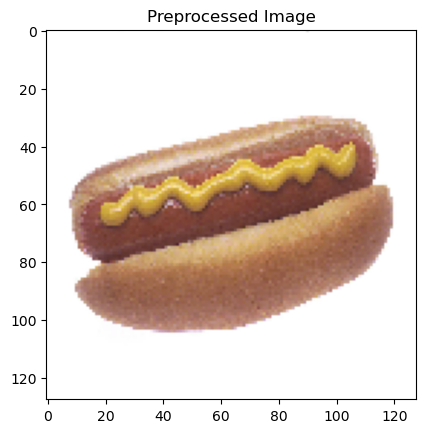

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Raw predictions: [[-3.4403458]]
Predicted class: 0


In [36]:
img = image.load_img('02.jpeg', target_size=(128, 128)) 

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array = img_array / 255.0

print(f'Image shape: {img_array.shape}')
print(f'Image type: {img_array.dtype}')
print(f'Image pixel range: {img_array.min()} to {img_array.max()}')


plt.imshow(img_array[0])
plt.title('Preprocessed Image')
plt.show()

# Make predictions
predictions = model.predict(img_array)

# Print raw predictions to debug
print(f'Raw predictions: {predictions}')

# Interpret the predictions (this depends on your model's output format)
predicted_class = np.argmax(predictions, axis=1)

print(f'Predicted class: {predicted_class[0]}')


In [24]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

2024-06-26 13:00:04.305566: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-26 13:00:04.340764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x1000 with 0 Axes>

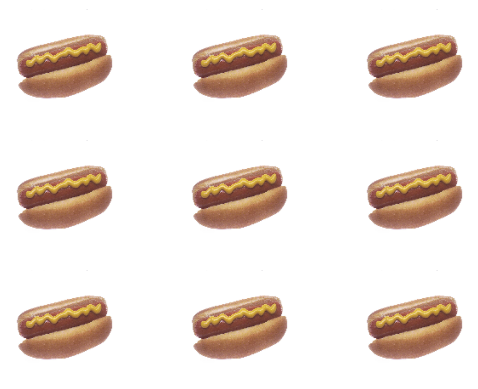

In [26]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)l
  plt.imshow(img)
  plt.axis("off")

In [32]:
labels[:1]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

In [36]:
img=cv2.imread('02.jpeg')    # read in the image - note cv2 reads in images in BGR format
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # model was trained on RGB images so convert to RGB
img=cv2.resize(img, (128,128)) # model was trained on images of size 128  X 128 X 3 so resize the images
img=img/127.5-1 # model was trained with pixel value scalled between -1 to +1 so convert the pixel range    
img=np.expand_dims(img, axis=0) # model predict expects the input to have dimension (batch_size, width, height, bands)
#print (img.shape)  # uncomment to see effect of expanding dimension
prediction =model.predict (img, batch_size=1, verbose=0) # make predictions    
pred=np.argmax(prediction)# find the index of the column with the highest probability
print (' the index of the predicted class is ', pred, ' with a probability of ', prediction[0][pred]  )

 the index of the predicted class is  0  with a probability of  -3.431578
